1. Getting Started 

Check data dimension :  (33713280, 1)


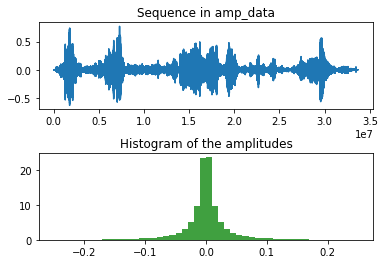

Check TrainSet Shape :  (1123775, 20) (1123775,)
Check ValidSet Shape :  (240809, 20) (240809,)
Check TestSet Shape :  (240809, 20) (240809,)



2. Curve fitting on a snippet of audio


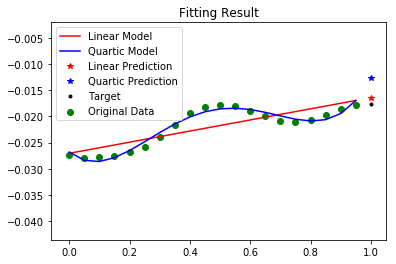

3. Choosing a polynomial predictor based on performance

<Compare two results from Q2 and Q3>
(C,K) =  20 2 / Q2 result :  [-0.01642552] / Q3 result :  -0.0164255242599
(C,K) =  20 5 / Q2 result :  [-0.01272737] / Q3 result :  -0.0127273654052

<Finding the most optimal C and K on three datasets>

C&K making the lowest err on the train set :  2.0 2.0
Train Set Err :  1.36360315774e-05

C&K making the lowest err on the validation set :  2.0 2.0
Valid Set Err :  1.36360315774e-05

C&K making the lowest err on the test set :  2.0 2.0
Test Set Err :  1.36360315774e-05



4. Fitting linear predictors across many snippets
 
C making the lowest mean square err on the training set and the err:  20 7.78933661891e-06
C making the lowest mean square err on the validation set and the err:  20 7.67512619644e-06
C making the lowest mean square err on the test set and the err:  20 7.50303685753e-06

<Plotting a histogram of the residuals on the validation data>


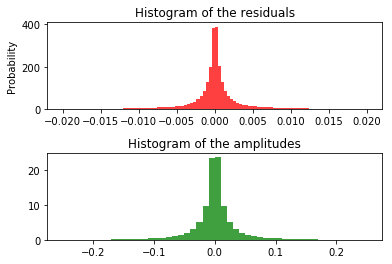

In [36]:
%matplotlib inline
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import math
import time

def DataReshape(data, col):
    #Data Reshape to C*21 and Shuffling
    row = data.shape[0] // col
    n_data = data[0:row*col, :].reshape(-1,col)
    np.random.seed(int(time.time()))
    np.random.shuffle(n_data)
    return n_data
    
def DataSplit(data, ratio):
    #Split the whole data into train, valid, test sets 
    train_flag = int(data.shape[0]*ratio[0])
    valid_flag = train_flag+1
    test_ratio = ratio[2]/(ratio[1]+ratio[2])
    test_flag = valid_flag + int((data.shape[0]-valid_flag)*(test_ratio))
    X_shuf_train = data[0:train_flag,0:20]
    y_shuf_train = data[0:train_flag,20]
    X_shuf_valid = data[valid_flag:test_flag,0:20]
    y_shuf_valid = data[valid_flag:test_flag,20]
    X_shuf_test = data[test_flag:,0:20]
    y_shuf_test = data[test_flag:,20]
    print('Check TrainSet Shape : ', X_shuf_train.shape, y_shuf_train.shape)
    print('Check ValidSet Shape : ', X_shuf_valid.shape, y_shuf_valid.shape)
    print('Check TestSet Shape : ', X_shuf_test.shape, y_shuf_test.shape)
    
    return [X_shuf_train, y_shuf_train, X_shuf_valid, y_shuf_valid, X_shuf_test, y_shuf_test]
        
def PolyModelFitting(dim, input_dim, input_x, input_y):
    #Make Polynomial Model with given dimension and input data & Predict output based on this model
    #Return weights, model and prediction
    power_array = np.array([np.power(input_x,t) for t in range(1,dim)])
    data = np.concatenate([np.ones(input_dim).reshape(1,-1), power_array],axis = 0).T
    fit = np.linalg.lstsq(data, input_y)[0]
    res = np.dot(fit.reshape(1,-1),data.T)
    pred = np.dot(fit.reshape(1,-1), np.ones(dim))
    return fit, res, pred

def Phi(C, K):
    phi_matrix = []
    for i in [float(t)/20.0 for t in range(20-C,20)]:
        feature = []
        for j in range(K):
            feature.append(i**j)
        phi_matrix.append(feature)
    return np.array(phi_matrix)

def make_vv(C, K):
    features = Phi(C,K)
    phi_1 = np.ones(K)
    a = np.linalg.inv(np.dot(features.T, features))
    return  np.dot(np.dot(features, a), phi_1)

def mean_squared_error(Y, X):
    return np.sum([np.power(Y-X,2)])/Y.shape[0]

def linearprediction_squared_error(Y, vector, X):
    return np.sum([np.power(Y-vector.T.dot(X),2)])/Y.shape[0]

def LinearPredictor(Y, X , C):
    # Predict using linear predictor
    n_X = X[:,19-C:20]
    A = np.dot(np.linalg.inv(np.dot(n_X.T,n_X)), n_X.T)
    pred = np.dot(A,Y)
    return pred

def Residual(Y, X, C):
    pred = LinearPredictor(Y,X,C)
    residual = np.dot(X[:,19-C:20],pred)-Y
    return residual

def main():
    ## 1. Getting Started
    print('1. Getting Started \n')
    data_path = '/afs/inf.ed.ac.uk/group/teaching/mlprdata/audio/amp_data.mat'
    data = io.loadmat(data_path)['amp_data']
    print('Check data dimension : ', data.shape)
    
    #plot histogram and linegraph
    figure, ax = plt.subplots(2)
    ax[0].plot(np.arange(data.shape[0]),data)
    ax[0].set_title('Sequence in amp_data')
    ax[1].hist(data, 50, normed=1, facecolor='g', alpha=0.75, range=[-.25, .25])
    ax[1].set_title('Histogram of the amplitudes')
    figure.subplots_adjust(hspace=0.5)
    plt.show()
    
    #Data Reshape, Shuffling, Split
    amp_data = DataReshape(data, 21)
    [train_X, train_y, valid_X, valid_y, test_X, test_y] = DataSplit(amp_data, [0.7, 0.15, 0.15])
    
    ##2. Curve fitting on a snippet of audio
    print('\n\n')
    print('='*100)
    print('2. Curve fitting on a snippet of audio')
    sample_input = np.arange(len(train_X[0]))/20.0
    obs_x = train_X[0]
    obs_y = train_y[0]
    
    #Linear model
    l_fit, l_res, l_pred = PolyModelFitting(2, 20, sample_input, obs_x)
    #Quartic model
    q_fit, q_res, q_pred  = PolyModelFitting(5, 20, sample_input, obs_x)
    plt.figure()
    plt.scatter(sample_input, obs_x, color='g', label = 'Original Data')
    plt.plot(sample_input, l_res.T, 'r', label = 'Linear Model')
    plt.plot(sample_input, q_res.T, 'b', label = 'Quartic Model')
    plt.plot(1.0, l_pred, 'r*', label = 'Linear Prediction')
    plt.plot(1.0, q_pred, 'b*', label = 'Quartic Prediction')
    plt.plot(1.0, obs_y, 'k.', label='Target')
    plt.title('Fitting Result')
    plt.legend()
    plt.show()
    
    ##3. Choosing a polynomial predictor based on performance
    print('='*100)
    print('3. Choosing a polynomial predictor based on performance')
    C=20
    K=2
    vector_K1 = make_vv(C,K)
    print('\n<Compare two results from Q2 and Q3>')
    print('(C,K) = ', C, K, '/ Q2 result : ', l_pred, '/ Q3 result : ', vector_K1.dot(obs_x.T))
    
    C=20
    K=5
    vector_K4 = make_vv(C,K)
    print('(C,K) = ', C, K, '/ Q2 result : ' ,q_pred, '/ Q3 result : ', vector_K4.dot(obs_x.T))
    
    #Setting K, C gives the smallest square error
    print('\n<Finding the most optimal C and K on three datasets>')
    res_train = []
    res_val = []
    res_test = []
    
    #for i in range(2,11):
     #   fit, res, pred = PolyModelFitting(i, sample_input, valid_X)
      #  print(mean_squared_error(valid_y, pred))
    
    for C in range(2,21):
        a = []
        b=[]
        c=[]
        for K in range(2,10):
            vector = make_vv(C,K)
            a.append(mean_squared_error(train_y, vector.dot(train_X[:,20-C:20].T)))
            b.append(mean_squared_error(valid_y, vector.dot(valid_X[:,20-C:20].T)))
            c.append(mean_squared_error(test_y, vector.dot(test_X[:,20-C:20].T)))
        res_train.append(a)
        res_val.append(b)
        res_test.append(c)

    
    #color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b']
    #plot_train = np.array(res_train).T
    #plt.figure(figsize=(10,10)) 
    #for i in range(7):
    #    num = 'K '+str(i+2)
    #    plt.plot(np.arange(2,21), np.array(res_train).T[i],color[i], label=num)
    #plt.title('Mean Squared Error based on C and K')
    #plt.xlabel('C')
    #plt.ylabel('MSE')
    #plt.legend()
    #plt.show()
    
    #Train Error
    res_train = np.array(res_train)
    arg_min  = res_train.argmin()
    ravel = res_train.ravel()[res_train.argmin()]
    div_m = divmod(arg_min, ravel)
    print('\nC&K making the lowest err on the train set : ',div_m[0]+2, div_m[1]+2)
    print('Train Set Err : ', res_train[int(div_m[0]),int(div_m[1])])
    
    #Validation Error
    res_val = np.array(res_val)
    arg_min  = res_val.argmin()
    ravel = res_val.ravel()[arg_min]
    div_m = divmod(arg_min, ravel)
    print('\nC&K making the lowest err on the validation set : ',div_m[0]+2, div_m[1]+2)
    print('Valid Set Err : ', res_train[int(div_m[0]),int(div_m[1])])    
    
    #Test Error 
    res_test = np.array(res_test)
    arg_min  = res_test.argmin()
    ravel = res_test.ravel()[arg_min]
    print('\nC&K making the lowest err on the test set : ',div_m[0]+2, div_m[1]+2)
    print('Test Set Err : ' ,res_train[int(div_m[0]),int(div_m[1])])
    
    
    ## 4. Fitting linear predictors across many snippets
    print('\n\n')
    print('='*100)
    print('4. Fitting linear predictors across many snippets')
    linear_train_err = []
    linear_valid_err = []
    linear_test_err = []
    
    for C in range(21):
        train_pred = LinearPredictor(train_y, train_X, C)
        linear_train_err.append(linearprediction_squared_error(train_y, train_pred.reshape(-1,1), train_X[:, 19-C:20].T)) 
        valid_pred = LinearPredictor(valid_y, valid_X, C)
        linear_valid_err.append(linearprediction_squared_error(valid_y, valid_pred.reshape(-1,1), valid_X[:, 19-C:20].T))
        test_pred = LinearPredictor(test_y, test_X, C)
        linear_test_err.append(linearprediction_squared_error(test_y, test_pred.reshape(-1,1), test_X[:, 19-C:20].T))
    
    train_C = np.array(linear_train_err).argmin()+1
    valid_C = np.array(linear_valid_err).argmin()+1
    test_C = np.array(linear_test_err).argmin()+1
    
    print(' ')
    print('C making the lowest mean square err on the training set and the err: ',train_C, linear_train_err[train_C-1])
    print('C making the lowest mean square err on the validation set and the err: ',train_C, linear_valid_err[valid_C-1])
    print('C making the lowest mean square err on the test set and the err: ',test_C, linear_test_err[test_C-1])
    
    print('\n<Plotting a histogram of the residuals on the validation data>')
    
    valid_residual = Residual(valid_y, valid_X, 20)
    figure, ax = plt.subplots(2)
    ax[0].hist(valid_residual, 100, normed=1, facecolor='r', alpha=0.75, range=[-.02, .02])
    ax[0].set_ylabel('Probability')
    ax[0].set_title('Histogram of the residuals')
    ax[1].hist(data, 50, normed=1, facecolor='g', alpha=0.75, range=[-.25, .25])
    ax[1].set_title('Histogram of the amplitudes')
    figure.subplots_adjust(hspace=0.5)
    plt.show()
    
    
if __name__ == "__main__":
    main()